In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs_revised.preprocessing import *
from custom_classes_defs_revised.Unet_like import *

#from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
#from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 100
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-05 17:53:54.799903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 17:53:54.800522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 17:53:55.019460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 17:53:55.409443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    strategy = tf.distribute.MirroredStrategy()
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Wed Jun  5 17:54:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   27C    P0              58W / 400W |    700MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   2  NVIDIA A100-SXM4-40GB          Off | 00000000:81:00.0 Off |                    0 |
| N/A   26C    P0              51W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   26C    P0              56W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()

seis_path = '../data_thebe/seismic/'
label_path = '../data_thebe/fault/'
thebe_data = Thebe(seis_path,label_path)

# Create datasets for respective data samples and labels
x_test, y_test = thebe_data.data_generator(sub_group='test',as_numpy=True)
        
print("Size of test data: {}".format(thebe_data.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Size of test data: 224122
...elapsed time: ___ 0.47 minutes___


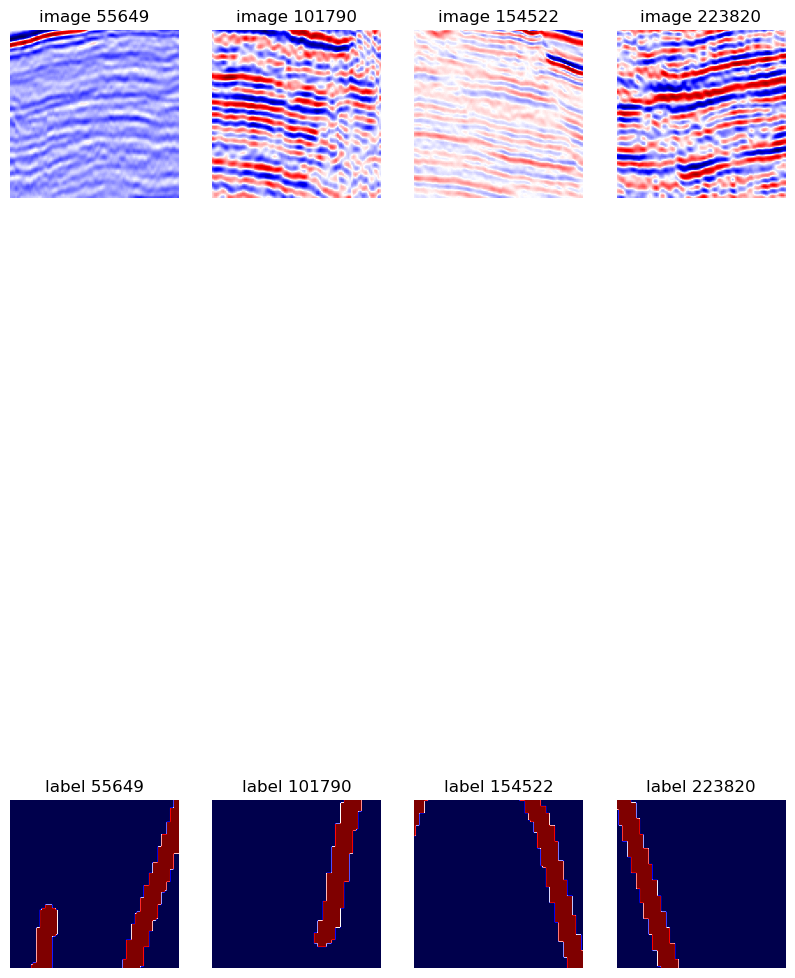

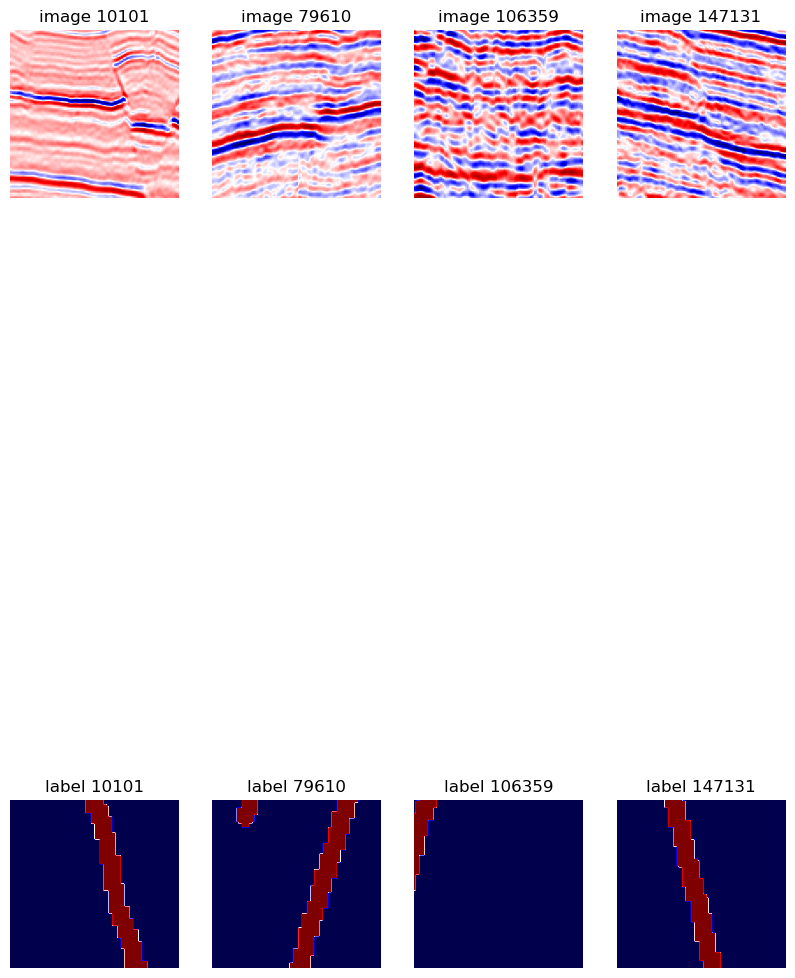

In [7]:
if INTERACTIVE_SESSION:
    thebe_data.display_sample_images(x_test, y_test, num_images=4)
    thebe_data.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/new/unetlike',
    img_shape=thebe_data.img_size,
    target_size=thebe_data.img_size,
    threshold=thebe_data.threshold,
    pos_label=thebe_data.pos_label,
    train_size=thebe_data.train_size,
    test_size=thebe_data.test_size,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=thebe_data.validation_size
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
           save_path: ./Thebe/new/unetlike
             scaling: 1
         target_size: (96, 96)
           test_size: 224122
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


2024-06-05 17:55:32.953398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
#m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model = m_obj.build_model()
# model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 2,057,825
Total trainable wieghts: 2,054,049
Total non-trainable wieghts: 3,776


### Train  model



	Train unet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/new/unetlike
             scaling: 1
         target_size: (96, 96)
           test_size: None
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
              

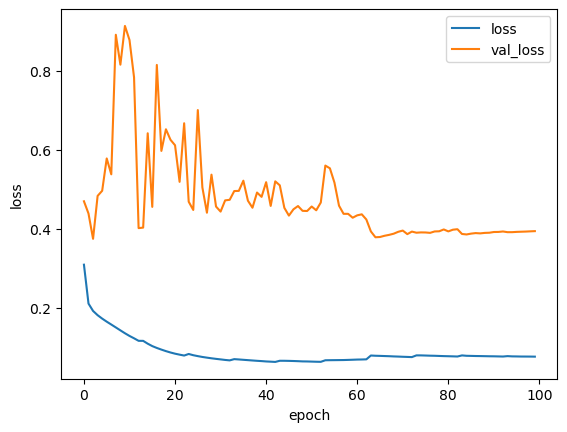

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=None, 
        plot_history=INTERACTIVE_SESSION
)


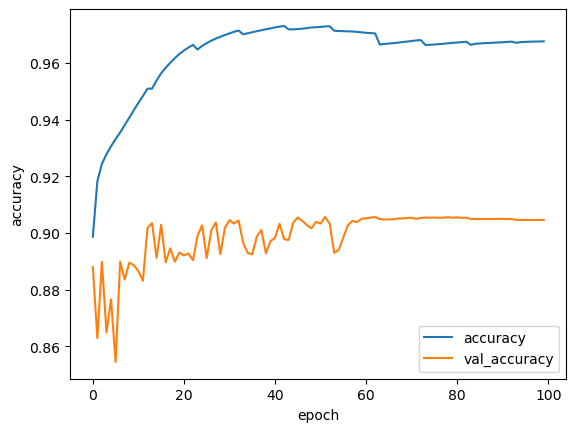

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

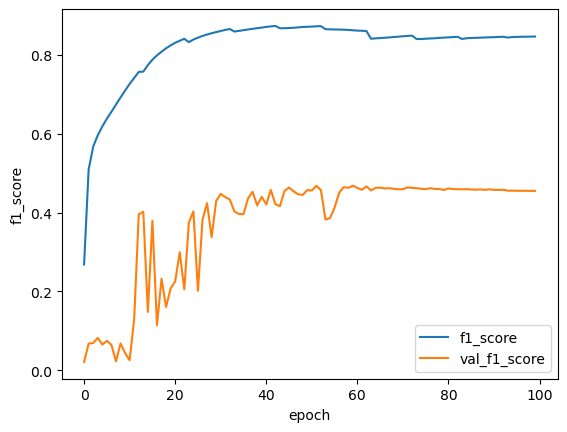

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

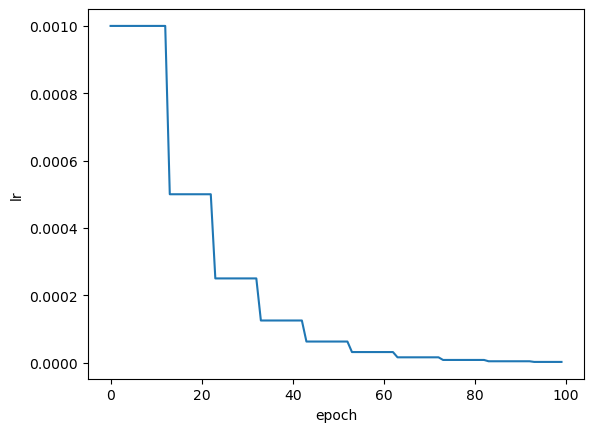

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate unet model
-------------------------------------------------------


2024-06-05 17:56:11.630724: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907



  1/438 [..............................] - ETA: 1:41:03


  3/438 [..............................] - ETA: 11s    


  5/438 [..............................] - ETA: 15s


  7/438 [..............................] - ETA: 16s


  9/438 [..............................] - ETA: 16s


 11/438 [..............................] - ETA: 17s


 13/438 [..............................] - ETA: 17s


 15/438 [>.............................] - ETA: 17s


 17/438 [>.............................] - ETA: 17s


 19/438 [>.............................] - ETA: 17s


 21/438 [>.............................] - ETA: 17s


 23/438 [>.............................] - ETA: 17s


 25/438 [>.............................] - ETA: 17s


 27/438 [>.............................] - ETA: 17s


 29/438 [>.............................] - ETA: 17s


 31/438 [=>............................] - ETA: 17s


 33/438 [=>............................] - ETA: 17s


 35/438 [=>............................] - ETA: 16s


 37/438 [=>............................] - ETA: 16s


 39/438 [=>............................] - ETA: 16s


 41/438 [=>............................] - ETA: 16s


 43/438 [=>............................] - ETA: 16s


 45/438 [==>...........................] - ETA: 16s


 47/438 [==>...........................] - ETA: 16s


 49/438 [==>...........................] - ETA: 16s


 51/438 [==>...........................] - ETA: 16s


 53/438 [==>...........................] - ETA: 16s


 55/438 [==>...........................] - ETA: 16s


 57/438 [==>...........................] - ETA: 16s


 59/438 [===>..........................] - ETA: 16s


 61/438 [===>..........................] - ETA: 16s


 63/438 [===>..........................] - ETA: 15s


 65/438 [===>..........................] - ETA: 15s


 67/438 [===>..........................] - ETA: 15s


 69/438 [===>..........................] - ETA: 15s


 71/438 [===>..........................] - ETA: 15s


 73/438 [====>.........................] - ETA: 15s


 75/438 [====>.........................] - ETA: 15s


 77/438 [====>.........................] - ETA: 15s


 79/438 [====>.........................] - ETA: 15s


 81/438 [====>.........................] - ETA: 15s


 83/438 [====>.........................] - ETA: 15s


 85/438 [====>.........................] - ETA: 15s


 87/438 [====>.........................] - ETA: 14s


 89/438 [=====>........................] - ETA: 14s


 91/438 [=====>........................] - ETA: 14s


 93/438 [=====>........................] - ETA: 14s


 95/438 [=====>........................] - ETA: 14s


 97/438 [=====>........................] - ETA: 14s


 99/438 [=====>........................] - ETA: 14s


101/438 [=====>........................] - ETA: 14s


103/438 [======>.......................] - ETA: 14s


105/438 [======>.......................] - ETA: 14s


107/438 [======>.......................] - ETA: 14s


109/438 [======>.......................] - ETA: 14s


111/438 [======>.......................] - ETA: 13s


113/438 [======>.......................] - ETA: 13s


115/438 [======>.......................] - ETA: 13s


117/438 [=======>......................] - ETA: 13s


119/438 [=======>......................] - ETA: 13s


121/438 [=======>......................] - ETA: 13s


123/438 [=======>......................] - ETA: 13s


125/438 [=======>......................] - ETA: 13s


127/438 [=======>......................] - ETA: 13s


129/438 [=======>......................] - ETA: 13s


131/438 [=======>......................] - ETA: 13s


133/438 [========>.....................] - ETA: 13s


135/438 [========>.....................] - ETA: 12s


137/438 [========>.....................] - ETA: 12s


139/438 [========>.....................] - ETA: 12s


141/438 [========>.....................] - ETA: 12s


143/438 [========>.....................] - ETA: 12s


145/438 [========>.....................] - ETA: 12s


147/438 [=========>....................] - ETA: 12s


149/438 [=========>....................] - ETA: 12s


151/438 [=========>....................] - ETA: 12s


153/438 [=========>....................] - ETA: 12s


155/438 [=========>....................] - ETA: 12s


157/438 [=========>....................] - ETA: 12s


159/438 [=========>....................] - ETA: 11s


161/438 [==========>...................] - ETA: 11s


163/438 [==========>...................] - ETA: 11s


165/438 [==========>...................] - ETA: 11s


167/438 [==========>...................] - ETA: 11s


169/438 [==========>...................] - ETA: 11s


171/438 [==========>...................] - ETA: 11s


173/438 [==========>...................] - ETA: 11s


175/438 [==========>...................] - ETA: 11s


177/438 [===========>..................] - ETA: 11s


179/438 [===========>..................] - ETA: 11s


181/438 [===========>..................] - ETA: 11s


183/438 [===========>..................] - ETA: 10s


185/438 [===========>..................] - ETA: 10s


187/438 [===========>..................] - ETA: 10s


189/438 [===========>..................] - ETA: 10s


191/438 [============>.................] - ETA: 10s


193/438 [============>.................] - ETA: 10s


195/438 [============>.................] - ETA: 10s


197/438 [============>.................] - ETA: 10s


199/438 [============>.................] - ETA: 10s


201/438 [============>.................] - ETA: 10s


203/438 [============>.................] - ETA: 10s


205/438 [=============>................] - ETA: 9s 


207/438 [=============>................] - ETA: 9s


209/438 [=============>................] - ETA: 9s


211/438 [=============>................] - ETA: 9s


213/438 [=============>................] - ETA: 9s


215/438 [=============>................] - ETA: 9s


217/438 [=============>................] - ETA: 9s


219/438 [==============>...............] - ETA: 9s


221/438 [==============>...............] - ETA: 9s


223/438 [==============>...............] - ETA: 9s


225/438 [==============>...............] - ETA: 9s


227/438 [==============>...............] - ETA: 9s


229/438 [==============>...............] - ETA: 8s


231/438 [==============>...............] - ETA: 8s


233/438 [==============>...............] - ETA: 8s


235/438 [===============>..............] - ETA: 8s


237/438 [===============>..............] - ETA: 8s


239/438 [===============>..............] - ETA: 8s


241/438 [===============>..............] - ETA: 8s


243/438 [===============>..............] - ETA: 8s


245/438 [===============>..............] - ETA: 8s


247/438 [===============>..............] - ETA: 8s


249/438 [================>.............] - ETA: 8s


251/438 [================>.............] - ETA: 8s


253/438 [================>.............] - ETA: 7s


255/438 [================>.............] - ETA: 7s


257/438 [================>.............] - ETA: 7s


259/438 [================>.............] - ETA: 7s


261/438 [================>.............] - ETA: 7s


263/438 [=================>............] - ETA: 7s


265/438 [=================>............] - ETA: 7s


267/438 [=================>............] - ETA: 7s


269/438 [=================>............] - ETA: 7s


271/438 [=================>............] - ETA: 7s


273/438 [=================>............] - ETA: 7s


275/438 [=================>............] - ETA: 6s


277/438 [=================>............] - ETA: 6s


279/438 [==================>...........] - ETA: 6s


281/438 [==================>...........] - ETA: 6s


283/438 [==================>...........] - ETA: 6s


285/438 [==================>...........] - ETA: 6s


287/438 [==================>...........] - ETA: 6s


289/438 [==================>...........] - ETA: 6s


291/438 [==================>...........] - ETA: 6s


293/438 [===================>..........] - ETA: 6s


295/438 [===================>..........] - ETA: 6s


297/438 [===================>..........] - ETA: 6s


299/438 [===================>..........] - ETA: 5s


301/438 [===================>..........] - ETA: 5s


303/438 [===================>..........] - ETA: 5s


305/438 [===================>..........] - ETA: 5s


307/438 [====================>.........] - ETA: 5s


309/438 [====================>.........] - ETA: 5s


311/438 [====================>.........] - ETA: 5s


313/438 [====================>.........] - ETA: 5s


315/438 [====================>.........] - ETA: 5s


317/438 [====================>.........] - ETA: 5s


319/438 [====================>.........] - ETA: 5s


321/438 [====================>.........] - ETA: 5s


323/438 [=====================>........] - ETA: 4s


325/438 [=====================>........] - ETA: 4s


327/438 [=====================>........] - ETA: 4s


329/438 [=====================>........] - ETA: 4s


331/438 [=====================>........] - ETA: 4s


333/438 [=====================>........] - ETA: 4s


335/438 [=====================>........] - ETA: 4s


337/438 [======================>.......] - ETA: 4s


339/438 [======================>.......] - ETA: 4s


341/438 [======================>.......] - ETA: 4s


343/438 [======================>.......] - ETA: 4s


345/438 [======================>.......] - ETA: 3s


347/438 [======================>.......] - ETA: 3s


349/438 [======================>.......] - ETA: 3s


351/438 [=======================>......] - ETA: 3s


353/438 [=======================>......] - ETA: 3s


355/438 [=======================>......] - ETA: 3s


357/438 [=======================>......] - ETA: 3s


359/438 [=======================>......] - ETA: 3s


361/438 [=======================>......] - ETA: 3s


363/438 [=======================>......] - ETA: 3s


365/438 [========================>.....] - ETA: 3s


367/438 [========================>.....] - ETA: 3s


369/438 [========================>.....] - ETA: 2s


371/438 [========================>.....] - ETA: 2s


373/438 [========================>.....] - ETA: 2s


375/438 [========================>.....] - ETA: 2s


377/438 [========================>.....] - ETA: 2s


379/438 [========================>.....] - ETA: 2s


381/438 [=========================>....] - ETA: 2s


383/438 [=========================>....] - ETA: 2s


385/438 [=========================>....] - ETA: 2s


387/438 [=========================>....] - ETA: 2s


389/438 [=========================>....] - ETA: 2s


391/438 [=========================>....] - ETA: 2s


393/438 [=========================>....] - ETA: 1s


395/438 [==========================>...] - ETA: 1s


397/438 [==========================>...] - ETA: 1s


399/438 [==========================>...] - ETA: 1s


401/438 [==========================>...] - ETA: 1s


403/438 [==========================>...] - ETA: 1s


405/438 [==========================>...] - ETA: 1s


407/438 [==========================>...] - ETA: 1s


409/438 [===========================>..] - ETA: 1s


411/438 [===========================>..] - ETA: 1s


413/438 [===========================>..] - ETA: 1s


415/438 [===========================>..] - ETA: 0s


417/438 [===========================>..] - ETA: 0s


419/438 [===========================>..] - ETA: 0s


421/438 [===========================>..] - ETA: 0s


423/438 [===========================>..] - ETA: 0s


425/438 [============================>.] - ETA: 0s


427/438 [============================>.] - ETA: 0s


429/438 [============================>.] - ETA: 0s


431/438 [============================>.] - ETA: 0s


433/438 [============================>.] - ETA: 0s


435/438 [============================>.] - ETA: 0s


437/438 [============================>.] - ETA: 0s


438/438 [==============================] - ETA: 0s


438/438 [==============================] - 34s 47ms/step


evaluation elapsed time:___ 0.78___minutes


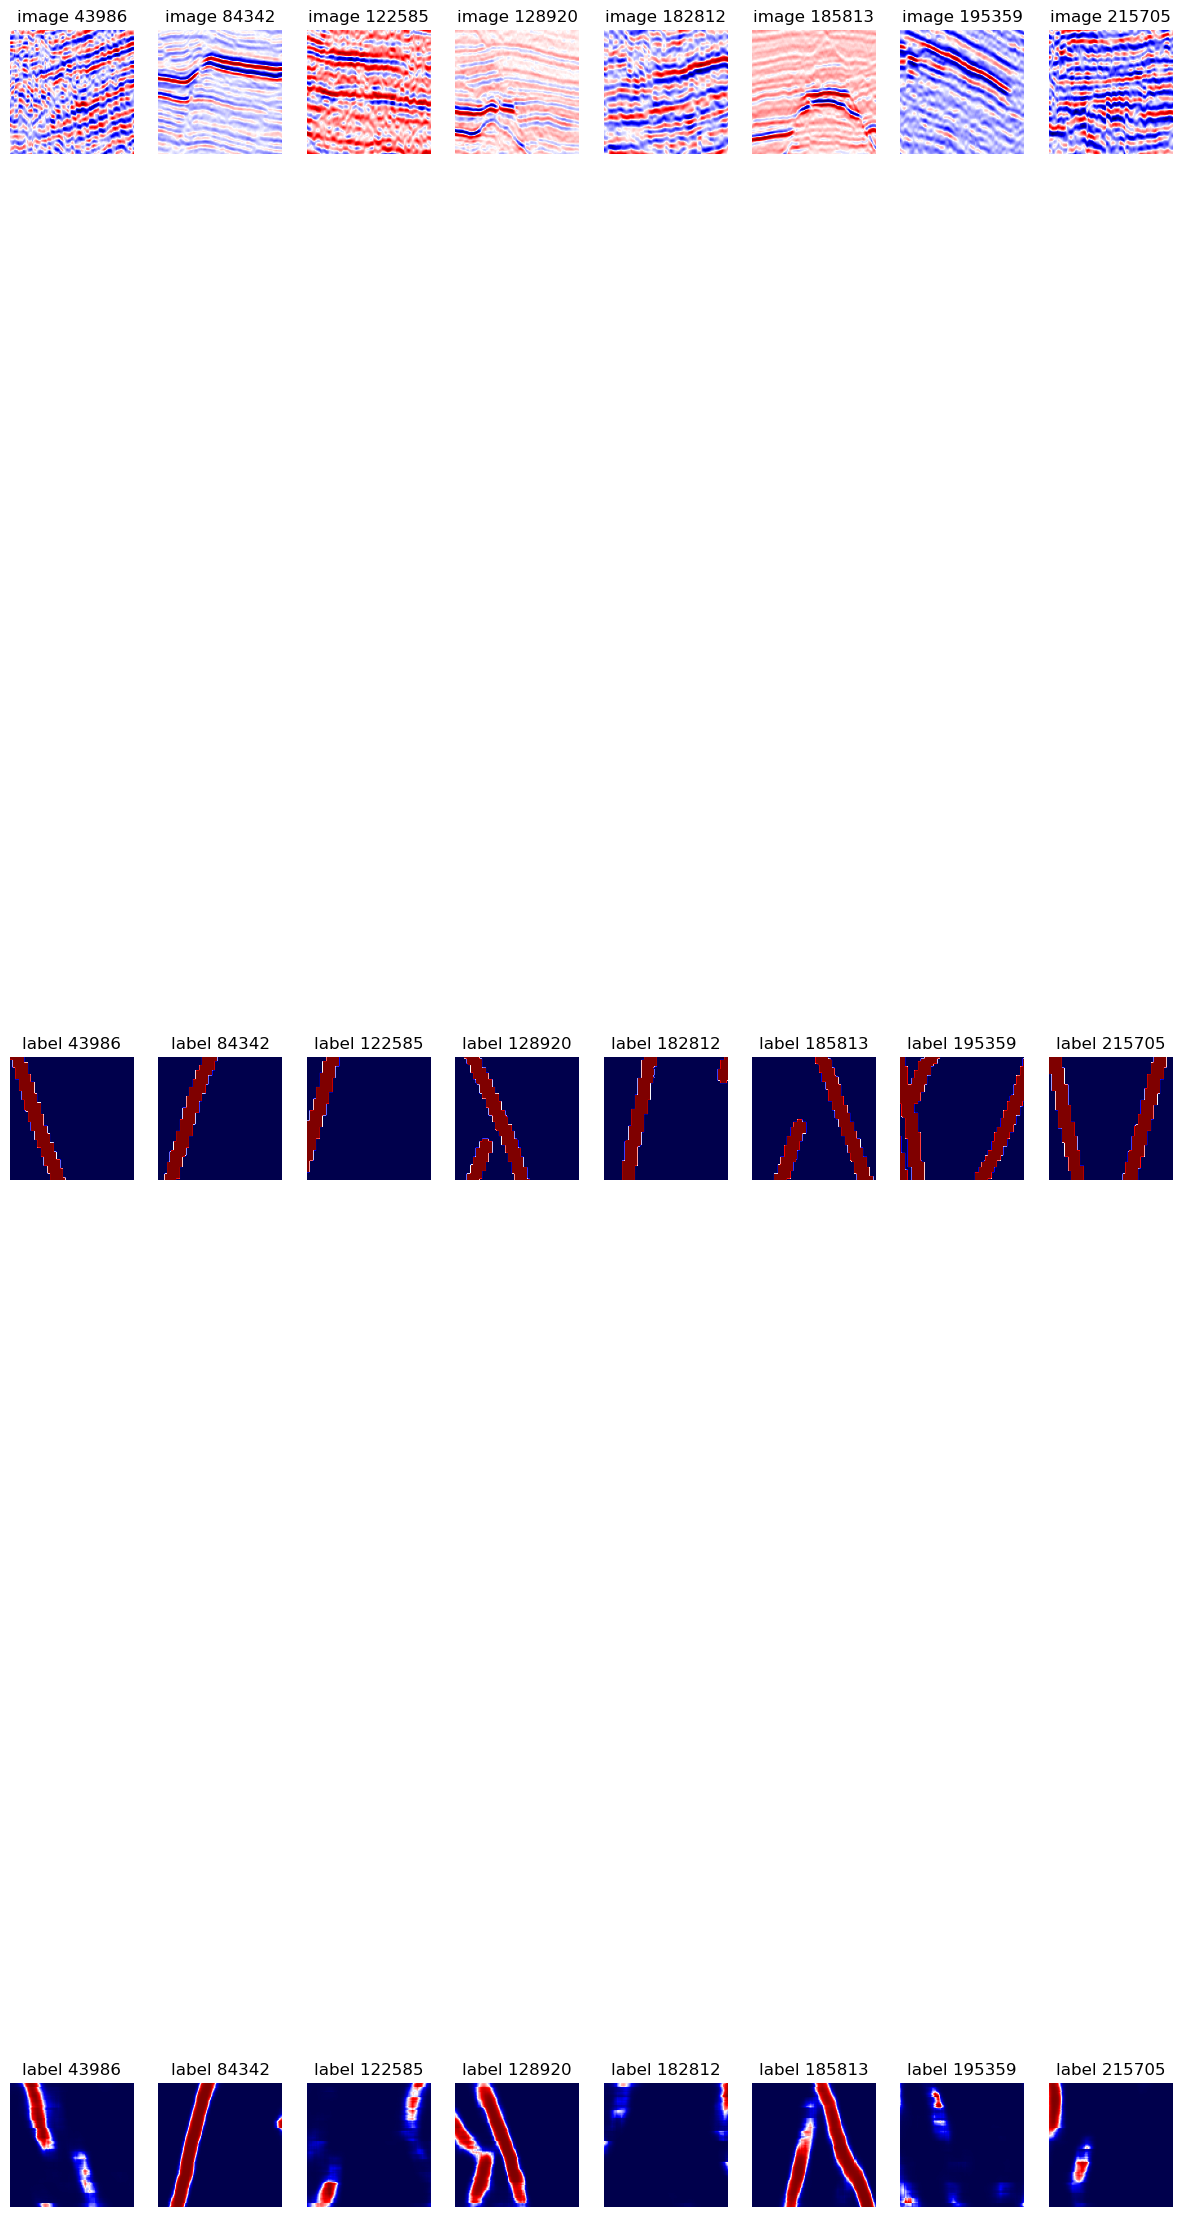

In [15]:

if INTERACTIVE_SESSION:
    thebe_data.display_sample_images(x_test, y_test, y_pred)
    

In [16]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___111.82___minutes


                      0             1  accuracy     macro avg  weighted avg
precision  9.800000e-01  2.000000e-01      0.59  5.900000e-01  9.000000e-01
recall     5.500000e-01  9.200000e-01      0.59  7.400000e-01  5.900000e-01
f1-score   7.100000e-01  3.300000e-01      0.59  5.200000e-01  6.700000e-01
support    1.841265e+09  2.242436e+08      0.59  2.065508e+09  2.065508e+09
{'Avg-precision': 0.57, 'f1-score(ODS)': 0.33}
